In [2]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Normalize
from PIL import Image


from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

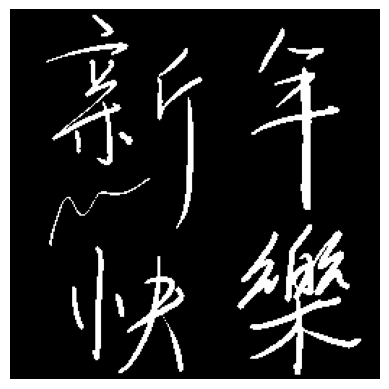

In [3]:
img = Image.open('images/image4.jpg').convert('L')
img = img.resize((256, 256), Image.LANCZOS)

img = np.array(img)
img = np.where(img >= 128, 0, 1).astype(np.uint8)


row,col = img.shape
for i in range(row):
    for j in range(col):
        print(img[i,j],end=' ')
    print('')

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


# img_b = Image.fromarray(img)
# img_b.save('images/resized_zju.png')

In [4]:
chip=CHIP(PS(host="192.168.1.10", port = 7, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 56022


In [6]:
def set_device(row,col,write_voltage,tg,pulse_width):
    chip.set_op_mode2(read=False,row=True,clearv=False)
    chip.set_pulse_width(pulse_width)
    chip.write2(row_index=[row],col_index=[col],write_voltage=write_voltage,tg=tg)

def reset_device(row,col,write_voltage,tg,pulse_width):
    chip.set_op_mode2(read=False,row=False,clearv=False)
    chip.set_pulse_width(pulse_width)
    chip.write2(row_index=[row],col_index=[col],write_voltage=write_voltage,tg=tg)

def read_device(row,col,read_voltage,tg):
    chip.set_op_mode2(read=True,row=True,clearv=False)
    vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=read_voltage,tg=tg,check_tia=True,sum=False)
    return 1/cres[0,0]*1e3

def read_crossbar():
    chip.set_op_mode2(read=True,row=True,clearv=False)
    resv,resc = np.zeros((256,256)),np.zeros((256,256))
    for k in range(32):
        row = k*8
        vres0,cres0 = chip.read2(row_index=[row,row+2,row+4,row+6],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)
        vres1,cres1 = chip.read2(row_index=[row+1,row+3,row+5,row+7],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

        for j in range(4):
            # print(resv[row+j*2],vres0[j])
            resv[row+j*2]=vres0[j]
            resv[row+1+j*2]=vres1[j]

            resc[row+j*2]=cres0[j]
            resc[row+1+j*2]=cres1[j]
    return 1/(resc+1e-20)*1e3

In [26]:
def write_and_verify(row,col,target):
    G = read_device(row,col,0.1,5)
    cont = 1
    while abs(G-target)>0.1*target:
        print(cont, end=': ') 
        if G<target:
            reset_device(row,col,1.6,5,5000e-6)
            G = read_device(row,col,0.1,5)
            print(f"{G:.2f}", end='RS  ')
        else:
            pulse_width = abs(G-target)/0.09*1e-9

            # set_device(row,col,3,map_k_vg[int(target)],min(pulse_width,10))
            set_device(row,col,2,2.5,min(pulse_width,10))
            G = read_device(row,col,0.1,5)
            print(f"{G:.2f}", end='SET   ')    
        
        cont = cont+1
        if cont>1:
            print(G)
            print("失败")
            break   
    return G

In [27]:
map_k_vg = [
    0,
    2.5,
    2.5,
    2.3,
    2.1,
    2.4,
    2.0,
    1.9,
    1.8,
    1.7,
    1.6
]

In [ ]:
import numpy as np

# 读取.npy文件
loaded_array = np.load('result/res_matrix0.npy')

# 打印数组
print(loaded_array)

In [7]:
res_matrix = read_crossbar()

TypeError: CHIP.set_op_mode2() got an unexpected keyword argument 'row'

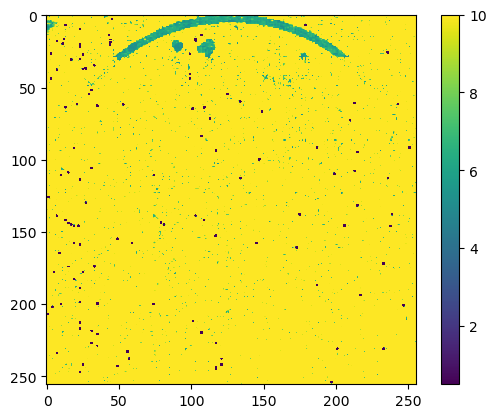

In [47]:
cmap = plt.cm.viridis
norm = Normalize(vmin=4, vmax=10)
im = plt.imshow(res_matrix, cmap=cmap,norm=norm)

cbar = plt.colorbar(im)

In [ ]:
row,col = img.shape
print(row,col)
for n in range(1):
    print(f"第{n}次")
    res_matrix = read_crossbar()
    np.save(f'result/res_matrix{n}.npy', res_matrix)
    err_rate = 0.1
    for i in range(row):
        print(f"第{i}行")
        for j in range(col):
            if img[i,j]==0 and res_matrix[i,j]<10:
                # reset_device(i,j,1.6,5,5000e-6)
                pass
            elif img[i,j]>0:
                target = 1/img[i,j]
                set_device(i,j,4,2.5,5500e-6)


256 256
第0次
第0行
第1行
第2行
第3行
第4行
第5行
第6行
第7行
第8行
第9行
第10行
第11行
第12行
第13行
第14行
第15行
第16行
第17行
第18行
第19行
第20行
第21行
第22行
第23行
第24行
第25行
第26行
第27行
第28行
第29行
第30行
第31行
第32行
第33行
第34行
第35行
第36行
第37行
第38行
第39行
第40行
第41行
第42行
第43行
第44行
第45行
第46行
第47行
第48行
第49行
第50行
第51行
第52行
第53行
第54行
第55行
第56行
第57行
第58行
第59行
第60行
第61行
第62行
第63行
第64行
第65行
第66行
第67行
第68行
第69行
第70行
第71行
第72行
第73行
第74行
第75行
第76行
第77行
第78行
第79行
第80行
第81行
第82行
第83行
第84行
第85行
第86行
第87行
第88行
第89行
第90行
第91行
第92行
第93行
第94行
第95行
第96行
第97行
第98行
第99行
第100行
第101行
第102行
第103行
第104行
第105行
第106行
第107行
第108行
第109行
第110行
第111行
第112行
第113行
第114行
第115行
第116行
第117行
第118行
第119行
第120行
第121行
第122行
第123行
第124行
第125行
第126行
第127行
第128行
第129行
第130行
第131行
第132行
第133行
第134行
第135行
第136行
第137行
第138行
第139行
第140行
第141行
